In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
 
import numpy as np

import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
#from skimage import measure
from skimage.metrics import mean_squared_error as mse

import os
import random

In [2]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

        

In [3]:
model1 = UNetDenoise()
summary(model1, (2, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,216
├─Conv2d: 1-2                            [-1, 64, 256, 256]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 128, 128, 128]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 64, 64]         --
├─Conv2d: 1-7                            [-1, 256, 64, 64]         295,168
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─MaxPool2d: 1-9                         [-1, 256, 32, 32]         --
├─Conv2d: 1-10                           [-1, 512, 32, 32]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 32, 32]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 16, 16]         --
├─Conv2d: 1-13                           [-1,

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,216
├─Conv2d: 1-2                            [-1, 64, 256, 256]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 128, 128, 128]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 64, 64]         --
├─Conv2d: 1-7                            [-1, 256, 64, 64]         295,168
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─MaxPool2d: 1-9                         [-1, 256, 32, 32]         --
├─Conv2d: 1-10                           [-1, 512, 32, 32]         1,180,160
├─Conv2d: 1-11                           [-1, 512, 32, 32]         2,359,808
├─MaxPool2d: 1-12                        [-1, 512, 16, 16]         --
├─Conv2d: 1-13                           [-1,

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #using gpu
print(device)

cuda:0


In [5]:
#dataset

In [6]:
class getDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) #handles label creation, class names for imgs
        
    def __len__(self): #to let dataloader know len of data
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    @property
    def classes(self):
        return self.data.classes

In [7]:
print(os.getcwd())

C:\Users\hanso\Desktop\projects_desktop\UNetDenoiser


In [8]:
#image preprocessing function

In [9]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x/255) #normalization by div by 255
    #transforms.Normalize(0,1)
])

In [10]:
print(os.getcwd())

C:\Users\hanso\Desktop\projects_desktop\UNetDenoiser


In [11]:
train_dir = 'imgDataset/Train400/'
test_dir = 'imgDataset/Test68/'
train_datasetPreSplit =getDataset(train_dir, preprocess)
test_dataset =getDataset(test_dir, preprocess)
train_dataset, val_dataset = random_split(train_datasetPreSplit, [int(0.85*len(train_datasetPreSplit)), len(train_datasetPreSplit)-int(0.85*len(train_datasetPreSplit))])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
image, label = train_dataset[1]
print(f'MIN: {image.min()}, Max: {image.max()}')
image.shape

MIN: 0.054901961237192154, Max: 0.9529411792755127


torch.Size([1, 256, 256])

In [14]:
#training loop

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5)#adam adjustes the learning rate. weight decay for l2 reg. Use 1e-4, 1e-3 for lr

In [16]:
def psnr(mse, max):
    return 10*np.log10((max**2)/mse)
    

In [17]:
dataset_size = 50
batch_size = 32
num_epochs = 10
model1.to(device)
sigma = 15/255 #maybe try 15
psnrMin = float('inf') #to keep track of smallest psnr val for saving wieghts

In [18]:
#lists to keep track of losses and metrics at end of an epoch
epochTrainLossList = list()
epochValLossList = list()
epochssimOutputList = list()
epochssimNoisyList = list()
epochpsnrNoisyList= list()
epochpsnrOutputList = list()

In [19]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [20]:
for epoch in range(num_epochs):
    #training
    model1.train()
    
    curBatch = 0
    trainLossList = list()
    valLossList = list()
   
    
    ssimOutputList = list()
    ssimNoisyList = list()
    psnrNoisyList= list()
    psnrOutputList = list()

     #image + noise, set sigma of noise(ex. 10/255), normalize the data. 
        #Then do clean_images+sigma*noisyimages
        #check on validation set
        #test set 
    
    for images, labels in train_loader:
        curBatch += 1
        clean_images = images.to(device)

        batchTrainLossList = list()
        
        for aCleanImg in clean_images:
            noiseGenerated = torch.randn_like(clean_images).to(device) 
           
            ###noise map implementation
            noiseMapSigmaSampled = torch.randint(1,50,(1,1)).item()#each image have diff sigma
            noiseMapSigma = noiseMapSigmaSampled/255
            imgNoisyInput = aCleanImg+sigma*noiseGenerated #sigma and noise map sigma are different
            modelInput = addNoiseMap(imgNoisyInput, noiseMapSigma)
            ####
            
            optimizer.zero_grad()
            outputs = model1(modelInput)
            
            # Compute the loss
            loss = criterion(outputs, aCleanImg)
            #need to compare with clean image
            loss.backward()
            optimizer.step()
            batchTrainLossList.append(loss.item())

        trainLossList.append(sum(batchTrainLossList)/len(batchTrainLossList))

        #validation should have 1 sigma value throguhout training loop
        model1.eval()
        with torch.no_grad():

            #sigma for noise map, fixed for all runs
            noiseMapSigmaSampled = torch.randint(1,50,(1,1)).item()
            noiseMapSigma = noiseMapSigmaSampled/255
            
            for images, labels in val_loader:

                batchValLossList = list()
                
                clean_images = images.to(device)
                noiseGenerated = torch.randn_like(clean_images).to(device) 


                ### noiseMap implementation
                imgNoisyInput = clean_images+sigma*noiseGenerated  
                modelInput = addNoiseMap(imgNoisyInput, noiseMapSigma)
                
                
                for anCleanImage, anInput, aNoisyImage in zip(clean_images, modelInput, imgNoisyInput): #anInput is the nosiy image

                    anOutput = model1(anInput)
                    loss = criterion(anOutput, anCleanImage)
                    batchValLossList.append(loss.item())

                    # Convert tensors to numpy arrays and map values to [0, 1] range
                    anCleanImage = (anCleanImage.cpu().detach().numpy())    #+1 then divide by 2 to make image pixels fall within range of SSIM.
                    anOutput = (anOutput.cpu().detach().numpy())  #don't have to do these 3 lines if normalized by /255
                    anInput = ((anInput.cpu().detach().numpy())).astype(np.float32)
                    aNoisyImage = (aNoisyImage.cpu().detach().numpy())
                    
                    #calculating SSIM
                    ssimOutputCalc = ssim(anCleanImage.squeeze(), anOutput.squeeze(), data_range=1)
                    ssimNoisyCalc = ssim(anCleanImage.squeeze(), aNoisyImage.squeeze(), data_range=1) #just take channel of actual image for input
                    ssimOutputList.append(ssimOutputCalc)
                    ssimNoisyList.append(ssimNoisyCalc)

                    #calculating MSE
                    mseNoised = mse(anCleanImage.squeeze(), aNoisyImage.squeeze())
                    mseOutput = mse(anCleanImage.squeeze(), anOutput.squeeze())
                    #calc psnr
                    psnrNoised = psnr(mseNoised, 1)
                    psnrOutput=psnr(mseOutput, 1)
                    psnrNoisyList.append(psnrNoised)
                    psnrOutputList.append(psnrOutput)

            valLossList.append(sum(batchValLossList)/len(batchValLossList))
            print(f" Batch: {curBatch} Of: {len(train_loader)}, Training Loss: {trainLossList[-1]:.4f}, Validation loss: {valLossList[-1]:.4f} Avg SSIM of noisy images: {sum(ssimNoisyList)/len(ssimNoisyList):.4f} Avg SSIM of output images: {sum(ssimOutputList)/len(ssimOutputList):.4f} | Avg PSNR of noisy images: {sum(psnrNoisyList)/len(psnrNoisyList):.4f}  Avg PSNR of output images: {sum(psnrOutputList)/len(psnrOutputList):.4f}")


                        
    epochTrainLossList.append(sum(trainLossList)/len(trainLossList))
    epochValLossList.append(sum(valLossList)/len(valLossList))
    epochssimOutputList.append(sum(ssimOutputList)/len(ssimOutputList))
    epochssimNoisyList.append(sum(ssimNoisyList)/len(ssimNoisyList))
    epochpsnrNoisyList.append(sum(psnrNoisyList)/len(psnrNoisyList))
    epochpsnrOutputList.append(sum(psnrOutputList)/len(psnrOutputList))

    avgEpochPsnr = sum(psnrOutputList)/len(psnrOutputList)
    #updating wieghts based on based psnr
    if avgEpochPsnr < psnrMin:
        torch.save(model1.state_dict(), "denoiserModelBestWeightswNoiseMap.pth")
        psnrMin = avgEpochPsnr
    #updating weights every 10 epochs
    if epoch % 10 == 0:
        torch.save(model1.state_dict(), "denoiserWeightsCheckpointwNoiseMap.pth") 
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {sum(trainLossList)/len(trainLossList):.4f}, Validation Loss: {sum(valLossList)/len(valLossList):.4f}")

C:\Users\hanso\miniconda3\envs\pyTorchEnv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([32, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

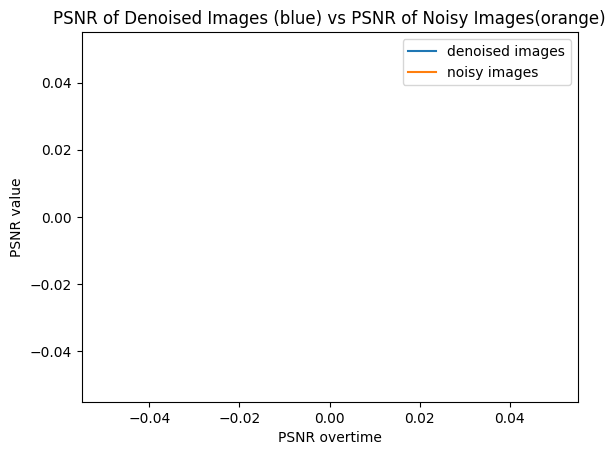

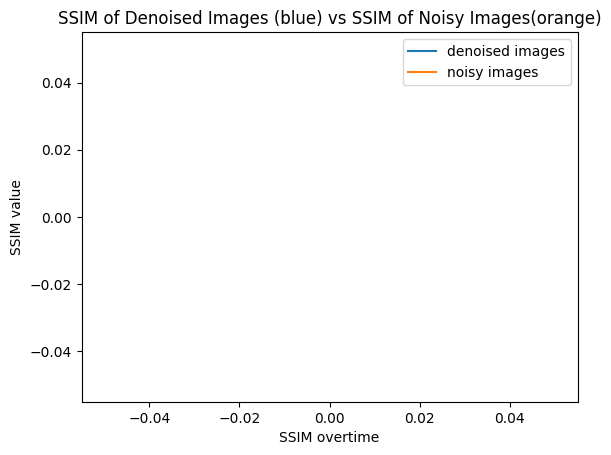

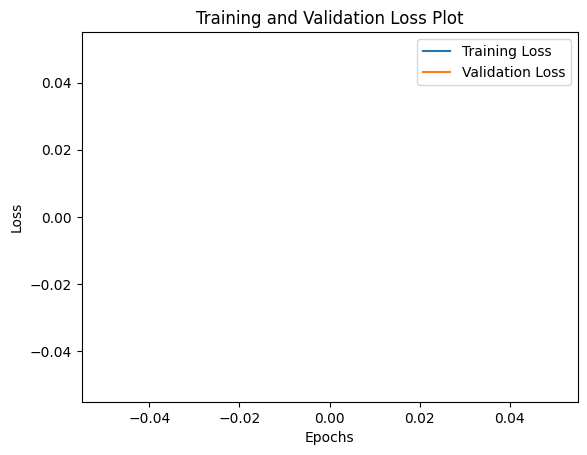

In [21]:
#plotting PSNR
numPsnrVals = len(epochpsnrOutputList)
plt.plot(range(numPsnrVals), epochpsnrOutputList, label="denoised images")
plt.plot(range(numPsnrVals), epochpsnrNoisyList, label="noisy images")
plt.xlabel('PSNR overtime')
plt.ylabel('PSNR value')
plt.legend()
plt.title('PSNR of Denoised Images (blue) vs PSNR of Noisy Images(orange)')
plt.show()

#plotting SSIM
numSSIMVals = len(epochssimOutputList)
plt.plot(range(numSSIMVals), epochssimOutputList, label="denoised images")
plt.plot(range(numSSIMVals), epochssimNoisyList, label="noisy images")
plt.xlabel('SSIM overtime')
plt.ylabel('SSIM value')
plt.legend()
plt.title('SSIM of Denoised Images (blue) vs SSIM of Noisy Images(orange)')
plt.show()

#plotting Losses
numEpochs = len(epochTrainLossList)
plt.plot(range(numEpochs), epochTrainLossList, label="Training Loss")
plt.plot(range(numEpochs), epochValLossList, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Plot')
plt.show()

In [22]:
# final weights save
torch.save(model1.state_dict(), "denoiserFinalWeightswNoiseMap.pth") 

In [23]:
#testing model on test set

In [24]:
model1.eval()
sigma=15/255
noiseMapSigmaSampled = torch.randint(1,50,(1,1)).item()
noiseMapSigma = noiseMapSigmaSampled/255
for images, labels in test_loader:
    imgNoisyInput = images+sigma*torch.randn_like(images) #adding more noise, imageswNoise denotes images with added noise
    ###noise map implementation
    imageNoised = addNoiseMap(imgNoisyInput, noiseMapSigma) #imageNoised denotes added noised image with noise map   
    ###
    #imagesNoised = images
    imageNoised=imageNoised.to(device)
    with torch.no_grad():
        denoised_imgs = model1(imageNoised)
    
    # Convert tensors to numpy arrays and move to CPU
    imageNoised = imageNoised.cpu().numpy()
    denoised_imgs = denoised_imgs.cpu().numpy()
    clean_imgsCpy = images #used to get 2 channels on clean image
    clean_imgs = images.cpu().numpy()
    imgNoisyInput = imgNoisyInput.cpu().numpy()
    
    num_imgs = len(imageNoised)
    fig, axes = plt.subplots(num_imgs, 3, figsize=(7, num_imgs * 6))
    
    for i in range(num_imgs):
        axes[i, 0].imshow(clean_imgs[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Clean Test Image Input')
        #axes[i, 0].axis('off')
        
        axes[i, 1].imshow(imageNoised[i][0].squeeze(), cmap='gray')
        axes[i, 1].set_title('Image with added Noise')
       # axes[i, 1].axis('off')
        empty_channel = torch.zeros_like(clean_imgsCpy[i])
        cleanImg2Chan = np.concatenate((clean_imgsCpy[i], empty_channel), axis=0)
        
        
        ssimCalcNoised = ssim(clean_imgs[i].squeeze(), imgNoisyInput[i].squeeze(), data_range=1)
        mseOutNoised = mse(imgNoisyInput[i].squeeze(), clean_imgs[i].squeeze()) #psnr between test(noisy) image and denoised
        psnrOutNoised = psnr(mseOutNoised, 1)
        axes[i, 1].set_xlabel(f'PSNR: {psnrOutNoised:.4f}, SSIM: {ssimCalcNoised:.4f}')
        
        # Plot the denoised output image
        axes[i, 2].imshow(denoised_imgs[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Denoised Output Image')
        ssimCalcDenoised = ssim(clean_imgs[i].squeeze(), denoised_imgs[i].squeeze(), data_range=1)
        mseOutDenoised = mse(denoised_imgs[i].squeeze(), clean_imgs[i].squeeze()) #psnr between test(noisy) image and denoised
        psnrOutDenoised = psnr(mseOutDenoised, 1)
        axes[i, 2].set_xlabel(f'PSNR: {psnrOutDenoised:.4f}, SSIM: {ssimCalcDenoised:.4f}')
        #axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
    break;

KeyboardInterrupt: 